## Семинар 8: "Снижение размерности"

ФИО: Подоприхин Максим Александрович

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

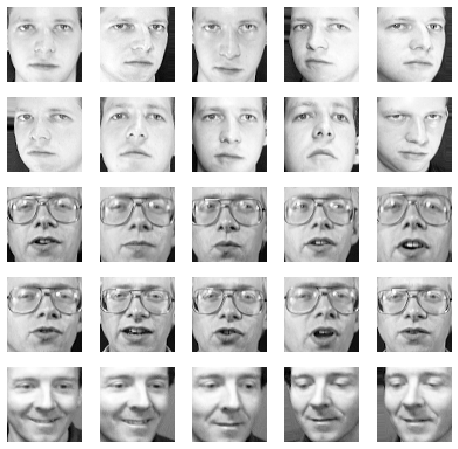

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
X.shape

(400, 4096)

In [6]:
model = PCA(n_components=25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
principle_components = model.components_

In [8]:
principle_components.shape

(25, 4096)

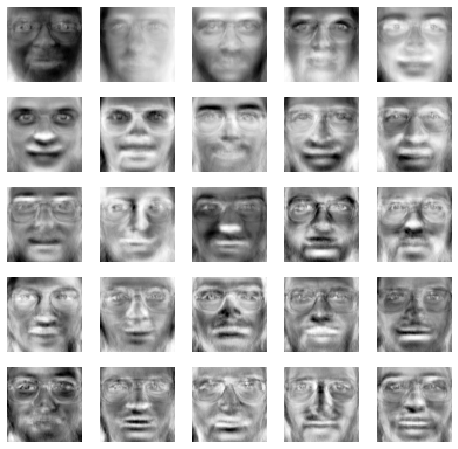

In [9]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте метод <b>.explained\_variance\_ratio\_</b>

In [10]:
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Reconstruction quality (MSE)')

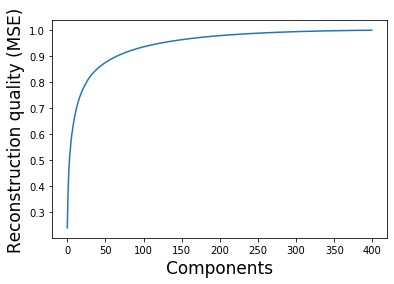

In [11]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)

In [17]:
model = PCA(n_components=122)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

Text(0.5, 1.0, 'Error')

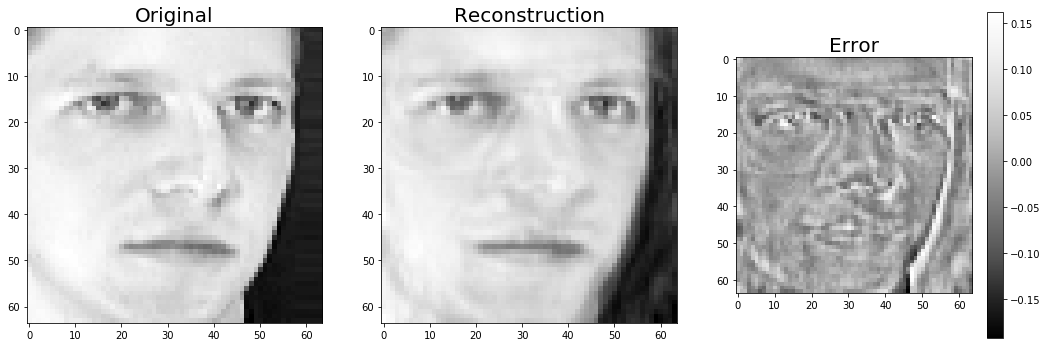

In [13]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

возпользуемся критерием, что критерий восстановление должен быть равен >= 0.95

In [20]:
model = PCA()
model.fit(X)
tmp = np.cumsum(model.explained_variance_ratio_)

In [23]:
for i in range(len(tmp)):
    if tmp[i] >= 0.95:
        print('components: ', i+1)
        break

components:  123


In [25]:
model = PCA(n_components=123)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

Text(0.5, 1.0, 'Error')

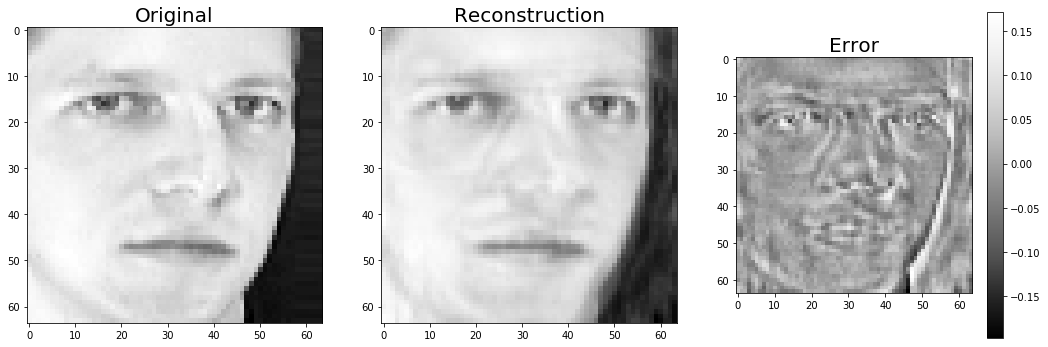

In [26]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [14]:
model = PCA(n_components=2)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

In [15]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

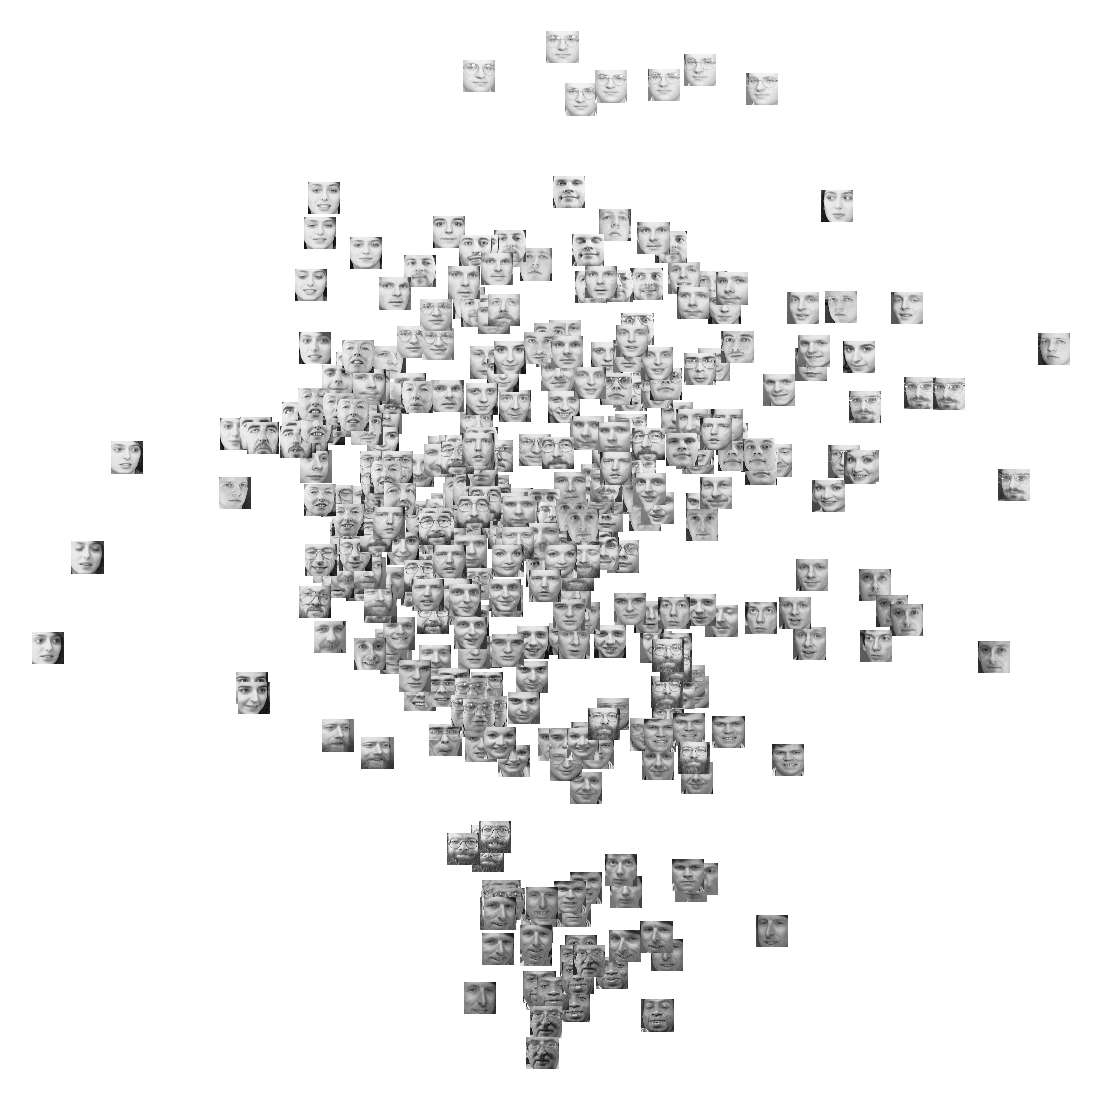

In [16]:
plot_dataset(X, embedding)

Первая компонента — освещение, вторая — в какую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [31]:
from torch.utils.data import DataLoader, Dataset

In [93]:
dataloader = DataLoader(X, batch_size=32, shuffle=True)

In [94]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [95]:
fully_connected([4096, 200, 10], last_nonlinearity=False)

Sequential(
  (0): Linear(in_features=4096, out_features=200, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=200, out_features=10, bias=True)
)

In [96]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        # create encoder:
        self.encoder = fully_connected(arc_encoder, last_nonlinearity=False)
        self.decoder = fully_connected(arc_decoder, last_nonlinearity=False)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [97]:
model = AE([4096, 200, 10], [10, 200, 4096])

In [98]:
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=4096, bias=True)
  )
)

In [99]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [100]:
import sys

In [101]:
for epoch in range(200):
    losses = []
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        #print(loss_batch.data.item())
        losses.append(loss_batch.data.item())
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.008851875801785635

In [102]:
X.shape

(400, 4096)

In [103]:
embedding = model.encoder(Variable(torch.Tensor(X))).data.numpy()

In [104]:
reconstruction = model(Variable(torch.Tensor(X))).data.numpy()

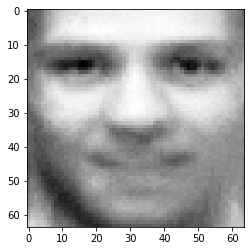

In [105]:
plt.imshow(reconstruction[300].reshape(64, 64), cmap=plt.cm.Greys_r)

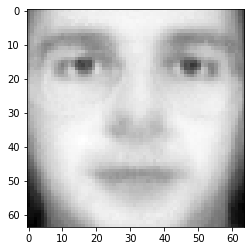

In [106]:
plt.imshow(reconstruction[0].reshape(64, 64), cmap=plt.cm.Greys_r)

In [83]:
reconstruction[0] == reconstruction[300] 

array([False, False, False, ..., False, False, False])

<i> 2.2 Какое качество восстановления удалось получить?</i>

0.008851875801785635

(-0.5, 63.5, 63.5, -0.5)

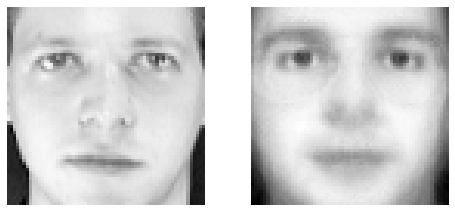

In [107]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(X[0].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(reconstruction[0].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

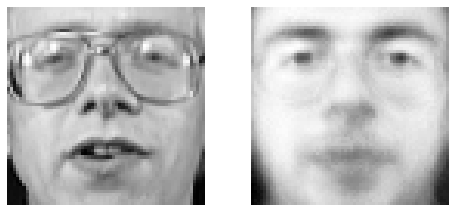

In [108]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(X[10].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(reconstruction[10].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.axis('off')

получилось не очень хорошо

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [109]:
from tqdm import tqdm

In [112]:
all_losses = []
encoders = []
decoders = []
decode_dim = [2, 50, 100, 200, 400, 800, 1500]

for i in tqdm(decode_dim):
    encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, i))
    decoder = nn.Sequential(nn.Linear(i, 200), nn.Linear(200, 4096))
    params = list(encoder.parameters()) + list(decoder.parameters())
    opt = optim.Adam(params=params, lr=0.002)
    loss_func = nn.MSELoss()
    epoch = 120
    losses = []

    for e in range(epoch):
        for batch in dataloader:
            x = Variable(torch.FloatTensor(batch))
            y = Variable(torch.FloatTensor(batch), requires_grad=False)

            x_pred = encoder(x)
            y_pred = decoder(x_pred)

            loss = loss_func(y_pred, y)
            losses.append(np.array(loss.data))
            opt.zero_grad()
            loss.backward()
            opt.step()
            
    encoders.append(encoder)
    decoders.append(decoder)
    all_losses.append([i, np.min(losses)])



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 14%|████████████                                                                        | 1/7 [01:12<07:12, 72.11s/it]

 29%|████████████████████████                                                            | 2/7 [02:24<06:00, 72.04s/it]

 43%|████████████████████████████████████                                                | 3/7 [03:35<04:47, 71.89s/it]

 57%|████████████████████████████████████████████████                                    | 4/7 [04:50<03:38, 72.67s/it]

 71%|████████████████████████████████████████████████████████████                        | 5/7 [05:54<02:20, 70.34s/it]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [07:03<01:09, 69.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [08:24<00:00, 72.08s/it]


<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

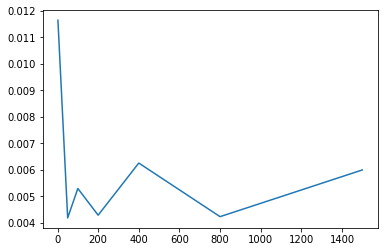

In [113]:
all_losses = np.array(all_losses)
plt.plot(all_losses[:, 0], all_losses[:, 1])

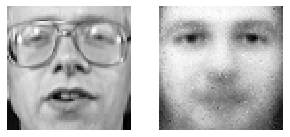

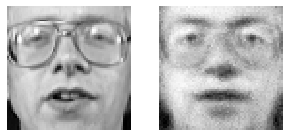

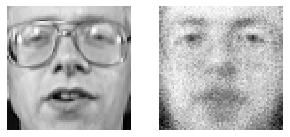

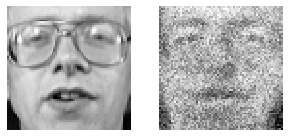

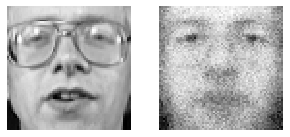

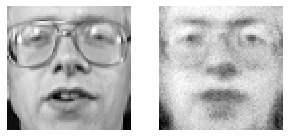

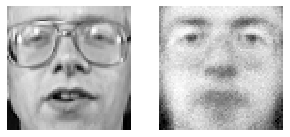

In [114]:
idx = 10

for i, encoder in enumerate(encoders):
    x_enc = encoder(Variable(torch.FloatTensor(X[idx])))
    x_dec = decoders[i](x_enc)

    plt.figure(figsize=(5, 5))
    plt.subplot(2, 2, 1)
    plt.imshow(X[idx].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(np.array(x_dec.data).reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
    plt.show()

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [119]:
encoder = nn.Sequential(nn.Linear(4096, 200), nn.Linear(200, 2))
decoder = nn.Sequential(nn.Linear(2, 200), nn.Linear(200, 4096))
params = list(encoder.parameters()) + list(decoder.parameters())
opt = optim.Adam(params=params, lr=0.001)
loss_func = nn.MSELoss()
epoch = 250
losses = []

for e in range(epoch):
    for batch in dataloader:
        x = Variable(torch.FloatTensor(batch))
        y = Variable(torch.FloatTensor(batch), requires_grad=False)

        x_pred = encoder(x)
        y_pred = decoder(x_pred)

        loss = loss_func(y_pred, y)
        losses.append(np.array(loss.data))
        opt.zero_grad()
        loss.backward()
        opt.step()

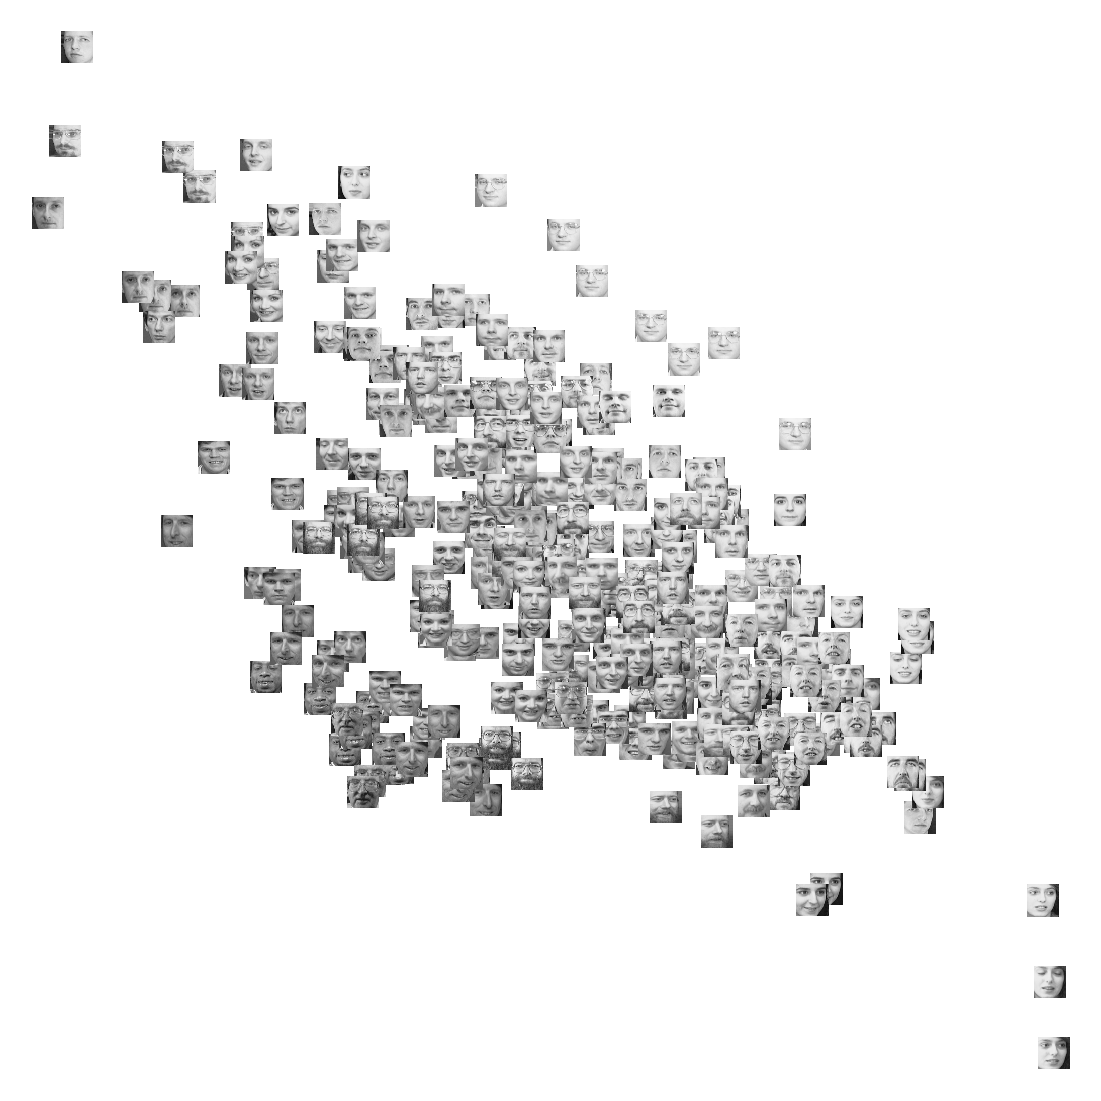

In [120]:
embed = np.array(encoder(torch.Tensor(X)).data)
plot_dataset(X, embed)

Снова, если рассматривать картинки близкие друг к другу, то они досататочно похожи, также може заметить, что слева направо лица людей меняют направление взгляда.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: